In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from bing_helper import load_json_files, get_hits_from_json, load_lang_news_hits
from regression import fit_regression_and_rename_coeffs_by_cat, fit_regression_and_rename_coeffs, write_reg_results
from processing import filter_by_region_cat_code, build_regression_dataframe, load_preprocessed_events
from plot_regression import plot_regression_results, plot_regression_results_interactions, plot_country_counts, plot_regression_results_interactions_from_dict, plot_cat_by_cat_variable
from preprocessing import load_if_in_country_or_lang
from steinkasserer.preprocessing import categorize_views_for_df

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load Data


In [2]:
df_crawled = load_preprocessed_events()
df_crawled = load_if_in_country_or_lang(df_crawled)
data = build_regression_dataframe(df_crawled)
df_crawled.head()

/home/ruptho/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ruptho/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,population,Country/Area,Year,GDP_pc,GDP,oecd,date_month,views_baseline,in_code_lang,in_code_region
0,Q100021,Pakistan International Airlines Flight 661,2016-12-07,Global South,Pakistan,Asia,disaster,"['Category:2016 disasters in Pakistan', 'Categ...",248274,0.000000,...,203631356,Pakistan,2016,1362.860008,2.775210e+11,False,2016-12-01,8.684000e+07,True,False
1,Q100231328,Gretchen Whitmer kidnapping plot,2020-10-08,Global North,United States,North America,disaster,"['Category:2020 crimes in the United States', ...",74144,0.000000,...,329484123,United States,2020,63122.594145,2.089375e+13,True,2020-10-01,3.137752e+09,True,True
2,Q100256872,Killing of Babu Lal Vaishnav,2020-10-08,Global South,India,Asia,disaster,"['Category:2020 crimes in India', 'Category:20...",427,0.000000,...,1380004385,India,2020,1930.971218,2.664749e+12,False,2020-10-01,7.142770e+08,True,False
3,Q100279235,Miss Vietnam 2020,2020-11-20,Global South,Vietnam,Asia,culture,"['Category:2020 beauty pageants', 'Category:Be...",1444,49.285714,...,97338583,Vietnam,2020,2785.724225,2.711584e+11,False,2020-11-01,1.619000e+07,False,False
4,Q100288161,2020 Ganja missile attacks,2020-10-11,Global South,Azerbaijan,Asia,disaster,"['Category:2020 in Azerbaijan', 'Category:Arti...",7410,0.000000,...,10093121,Azerbaijan,2020,4202.232239,4.260718e+10,False,2020-10-01,3.088000e+06,False,False


In [28]:
df_crawled = categorize_views_for_df(df_crawled)

In [29]:
df_crawled.head()

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,date_month,views_baseline,in_code_lang,in_code_region,views_baseline_cat
0,Q100021,Pakistan International Airlines Flight 661,2016-12-07,Global South,Pakistan,Asia,disaster,"['Category:2016 disasters in Pakistan', 'Categ...",248274,0.000000,...,Pakistan,2016,1362.860008,2.775210e+11,False,2016-12-01,8.684000e+07,True,False,>10^7
1,Q100231328,Gretchen Whitmer kidnapping plot,2020-10-08,Global North,United States,North America,disaster,"['Category:2020 crimes in the United States', ...",74144,0.000000,...,United States,2020,63122.594145,2.089375e+13,True,2020-10-01,3.137752e+09,True,True,>10^9
2,Q100256872,Killing of Babu Lal Vaishnav,2020-10-08,Global South,India,Asia,disaster,"['Category:2020 crimes in India', 'Category:20...",427,0.000000,...,India,2020,1930.971218,2.664749e+12,False,2020-10-01,7.142770e+08,True,False,>10^8
3,Q100279235,Miss Vietnam 2020,2020-11-20,Global South,Vietnam,Asia,culture,"['Category:2020 beauty pageants', 'Category:Be...",1444,49.285714,...,Vietnam,2020,2785.724225,2.711584e+11,False,2020-11-01,1.619000e+07,False,False,>10^7
4,Q100288161,2020 Ganja missile attacks,2020-10-11,Global South,Azerbaijan,Asia,disaster,"['Category:2020 in Azerbaijan', 'Category:Arti...",7410,0.000000,...,Azerbaijan,2020,4202.232239,4.260718e+10,False,2020-10-01,3.088000e+06,False,False,>10^6


# Poisson regression, Quasi-regression model, Non-negative binomial model
https://www.youtube.com/watch?v=jnKDQtDy0Bg

https://www.youtube.com/watch?v=uGKnoAw-PFQ

In [4]:
from processing import compute_mean_and_variance
import statsmodels.api as sm
from plot_regression import plot_pearson_residuals

In [34]:
# excluding all articles that have no category or less than 10 recorded views in the week after the event happened
df_filtered = df_crawled[(df_crawled.cat != 'undefined') & (df_crawled.views_7_sum > 10)]
data_filtered = build_regression_dataframe(df_filtered)

/home/ruptho/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ruptho/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='mean', ylabel='var'>

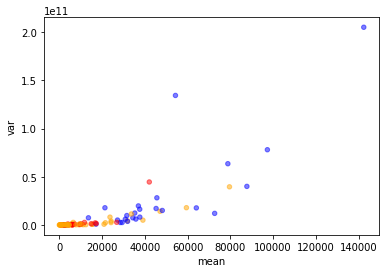

In [6]:
# mean-variance plot suggests to use negative binomial model! this is supported by poisson regression below (deviance >>>> DoF, very small error bars)
mean_var = compute_mean_and_variance(df_filtered, ['code', 'gni_region', 'cat'])['views_7_sum']
col_map = {'de': 'orange', 'en': 'blue', 'es': 'red', 'it': 'orange'}
col = [col_map[var[0]] for var in mean_var.index]
mean_var.plot.scatter(x='mean', y='var', color=col, alpha=0.5)

In [7]:
compute_mean_and_variance(df_filtered, ['code', 'gni_region', 'cat'])['views_7_sum']

mean           var
code gni_region            cat                                 
de   East Asia & Pacific   culture     266.333333  3.605733e+04
                           disaster  15254.400000  5.976131e+08
                           politics   5466.906250  3.057974e+07
                           sports     2646.382514  5.694921e+07
     Europe & Central Asia culture   11182.569620  1.937942e+08
...                                           ...           ...
it   South Asia            politics     69.500000  6.844500e+03
                           sports     1137.000000  1.630818e+06
     Sub-Saharan Africa    disaster   2054.666667  1.383099e+07
                           politics    292.928571  1.095870e+05
                           sports    10393.000000  5.819687e+08

[103 rows x 2 columns]

In [8]:
compute_mean_and_variance(df_filtered, 'gni_class')

views_7_sum              
                   mean           var
gni_class                            
H          25927.824198  2.182053e+10
L          26345.761194  4.042424e+09
LM         27390.089691  7.568149e+09
UM         23020.099937  1.482262e+10

### Poisson Regression

In [9]:
df_code = df_filtered[df_filtered.code == 'en']

In [10]:
model_ps = sm.GLM.from_formula('views_7_sum ~ cat * gni_class', family=sm.families.Poisson(), data=df_code).fit()
model_ps.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Generalized linear model
==================================================================================
Model:                    GLM                  AIC:                1080169578.9799
Link Function:            Log                  BIC:                1080023249.6438
Dependent Variable:       views_7_sum          Log-Likelihood:     -5.4008e+08    
Date:                     2022-03-04 08:47     LL-Null:            -5.6871e+08    
No. Observations:         7606                 Deviance:           1.0801e+09     
Df Model:                 15                   Pearson chi2:       5.62e+09       
Df Residuals:             7590                 Scale:              1.0000         
Method:                   IRLS                                                    
----------------------------------------------------------------------------------
                                 Coef.  Std.Err.     z      P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------
Intercept                       10.8004   0.0002 55268.8111 0.0000 10.8000 10.8008
cat[T.disaster]                  0.8605   0.0002  3494.3627 0.0000  0.8601  0.8610
cat[T.politics]                 -0.0793   0.0002  -346.0216 0.0000 -0.0797 -0.0788
cat[T.sports]                   -0.5643   0.0002 -2509.2747 0.0000 -0.5648 -0.5639
gni_class[T.L]                  -5.5927   0.0427  -130.9206 0.0000 -5.6764 -5.5090
gni_class[T.LM]                 -1.2597   0.0011 -1142.1850 0.0000 -1.2619 -1.2575
gni_class[T.UM]                 -0.6622   0.0009  -727.2578 0.0000 -0.6639 -0.6604
cat[T.disaster]:gni_class[T.L]   4.8507   0.0427   113.5442 0.0000  4.7670  4.9345
cat[T.politics]:gni_class[T.L]   5.1794   0.0427   121.2210 0.0000  5.0956  5.2631
cat[T.sports]:gni_class[T.L]     5.2208   0.0428   121.9968 0.0000  5.1369  5.3047
cat[T.disaster]:gni_class[T.LM]  0.5310   0.0012   458.0111 0.0000  0.5287  0.5332
cat[T.politics]:gni_class[T.LM]  1.0222   0.0012   872.8715 0.0000  1.0199  1.0245
cat[T.sports]:gni_class[T.LM]    1.4242   0.0012  1213.6062 0.0000  1.4219  1.4265
cat[T.disaster]:gni_class[T.UM]  0.0746   0.0010    76.7500 0.0000  0.0727  0.0765
cat[T.politics]:gni_class[T.UM]  0.2651   0.0010   269.9097 0.0000  0.2632  0.2671
cat[T.sports]:gni_class[T.UM]    0.9450   0.0009  1013.8470 0.0000  0.9432  0.9468
==================================================================================

"""

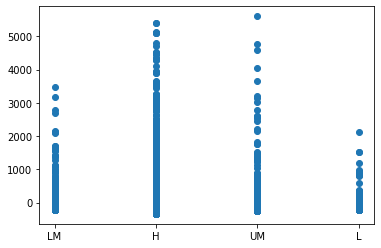

In [11]:
resid_outliers = model_ps.resid_pearson.nlargest(15)
outlier_filter = ~model_ps.resid_pearson.isin(resid_outliers)
plt.scatter(df_code.loc[outlier_filter, :].gni_class, model_ps.resid_pearson[outlier_filter])

In [12]:
# compute dispersion: ssqpearsonres / degrees of freedom

In [13]:
sum(np.square(model_ps.resid_pearson)) / model_ps.df_model

374400581.5530272

## Negative Binomial

In [14]:
model_neg_f = sm.GLM.from_formula('views_7_sum ~ cat * gni_region * code', family=sm.families.NegativeBinomial(),
                                  data=df_filtered)
model_neg = model_neg_f.fit()
model_neg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                14801
Model:                            GLM   Df Residuals:                    14698
Model Family:        NegativeBinomial   Df Model:                          102
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5734e+05
Date:                Fri, 04 Mar 2022   Deviance:                       57811.
Time:                        08:48:10   Pearson chi2:                 3.50e+05
No. Iterations:                   100   Pseudo R-squ. (CS):             0.6410
Covariance Type:            nonrobust                                         
=======================================================================================================================================
                                                                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                               5.5847      0.578      9.655      0.000       4.451       6.718
cat[T.disaster]                                                         4.0479      0.633      6.390      0.000       2.806       5.289
cat[T.politics]                                                         3.0217      0.605      4.996      0.000       1.836       4.207
cat[T.sports]                                                           2.2962      0.583      3.938      0.000       1.153       3.439
gni_region[T.Europe & Central Asia]                                     3.7374      0.589      6.342      0.000       2.582       4.892
gni_region[T.Latin America & Caribbean]                                -0.0630      0.248     -0.254      0.799      -0.548       0.422
gni_region[T.Middle East & North Africa]                                0.0064      1.157      0.005      0.996      -2.261       2.274
gni_region[T.North America]                                             5.1757      0.606      8.545      0.000       3.989       6.363
gni_region[T.South Asia]                                               -0.3950      0.184     -2.141      0.032      -0.756      -0.033
gni_region[T.Sub-Saharan Africa]                                       -0.8349      0.422     -1.978      0.048      -1.662      -0.008
code[T.en]                                                              3.9340      0.585      6.725      0.000       2.787       5.081
code[T.es]                                                              1.0033      0.818      1.227      0.220      -0.599       2.606
code[T.it]                                                             -1.8875      0.822     -2.296      0.022      -3.499      -0.276
cat[T.disaster]:gni_region[T.Europe & Central Asia]                    -3.0023      0.650     -4.617      0.000      -4.277      -1.728
cat[T.politics]:gni_region[T.Europe & Central Asia]                    -1.7697      0.619     -2.859      0.004      -2.983      -0.556
cat[T.sports]:gni_region[T.Europe & Central Asia]                      -2.9348      0.595     -4.933      0.000      -4.101      -1.769
cat[T.disaster]:gni_region[T.Latin America & Caribbean]                 0.4085      0.365      1.120      0.263      -0.307       1.124
cat[T.politics]:gni_region[T.Latin America & Caribbean]                -0.1474      0.317     -0.464      0.642      -0.770       0.475
cat[T.sports]:gni_region[T.Latin America & Caribbean]                   0.9661      0.263      3.679      0.000       0.451       1.481
cat[T.disaster]:gni_region[T.Middle East & North Africa]                0.3091      1.201  

ValueError: x and y must be the same size

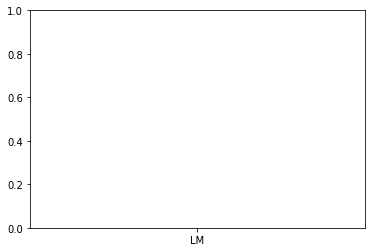

In [15]:
plt.scatter(df_filtered[df_filtered.code == 'en'].gni_class, model_neg.resid_pearson)

In [ ]:
plot_pearson_residuals(df_code, model_neg, 10, None)

In [ ]:
resid_outliers = model_ps.resid_pearson.nlargest(10)
outlier_filter = ~model_ps.resid_pearson.isin(resid_outliers)
fig, ax = plt.subplots()
ax.scatter(df_code.loc[outlier_filter, :].views_7_sum, model_ps.fittedvalues[outlier_filter])
ax.ticklabel_format(style='plain')

In [ ]:
df_filtered[df_filtered.code == 'de'].views_7_sum.plot.hist(bins=100)

In [ ]:
plt.scatter(model_neg.fittedvalues, model_neg.resid_pearson)

# Visualization

In [ ]:
df_filtered.groupby(['code', 'cat', 'gni_class']).size()

In [ ]:
df_filtered.nlargest(10, 'views_7_sum')

In [ ]:
from regression import fit_regression_and_rename_coeffs_by_cat

results_fit_separate = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                               formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_region, Treatment(reference='North America'))",
                                                               type='poisson')

fig_int_region_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                       results_fit_separate, ['cat:gni_region'],
                                                                       {'gni_class': 'H', 'in_code_lang': True,
                                                                        'gni_region': 'North America', 'cat': 'sports',
                                                                        'code': 'en'},
                                                                       label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                   'cat': ['sports', 'disaster',
                                                                                           'culture', 'politics'],
                                                                                   'gni_region': ['North America',
                                                                                                  'Europe & Central Asia',
                                                                                                  'Middle East & North Africa',
                                                                                                  'East Asia & Pacific',
                                                                                                  'South Asia',
                                                                                                  'Latin America & Caribbean',
                                                                                                  'Sub-Saharan Africa']},
                                                                       cat_dict={'en': 'English', 'it': 'Italian',
                                                                                 'es': 'Spanish', 'de': 'German'},
                                                                       title='views ~ gni_class * class (separate)',
                                                                       label_rename_dict={
                                                                           'Middle East & North Africa': 'MENAf',
                                                                           'Latin America & Caribbean': 'LatAmC',
                                                                           'Europe & Central Asia': 'EuCAs',
                                                                           'East Asia & Pacific': 'EAsP',
                                                                           'North America': 'NAm',
                                                                           'Sub-Saharan Africa': 'SSAf',
                                                                           'South Asia': 'SAs'},
                                                                       figsize=(13, 22), x_limits=(-6.5, 3),
                                                                       include_counts=True)

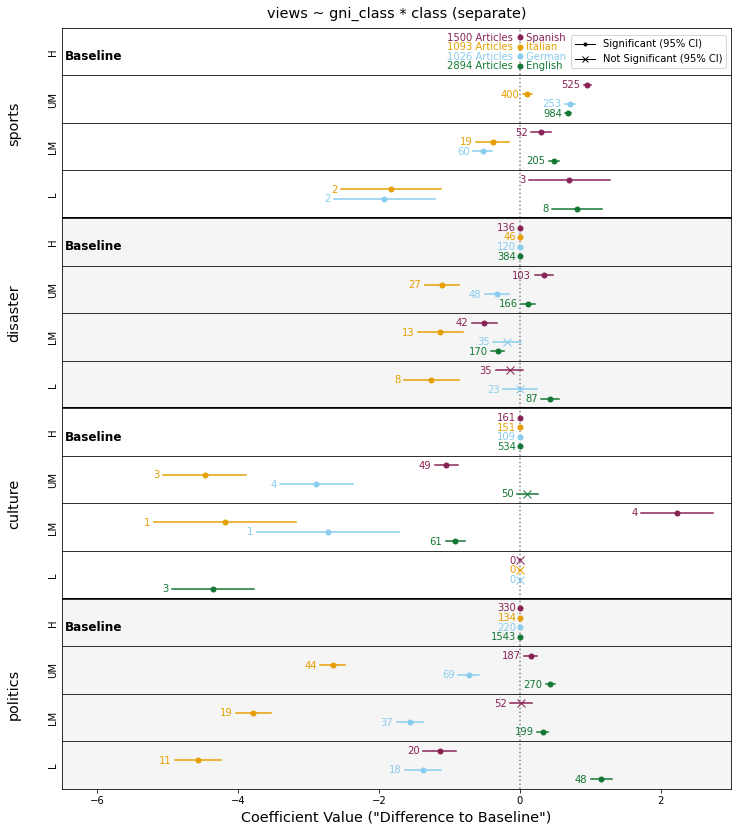

In [31]:
from regression import fit_regression_and_rename_coeffs_by_cat

results_fit_separate_class_control = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                             formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_class, Treatment(reference='H')) + np.log1p(views_baseline)",
                                                                             type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_class_control,
                                                                      ['cat:gni_class'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='views ~ gni_class * class (separate)',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 14), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_class_control.pdf')

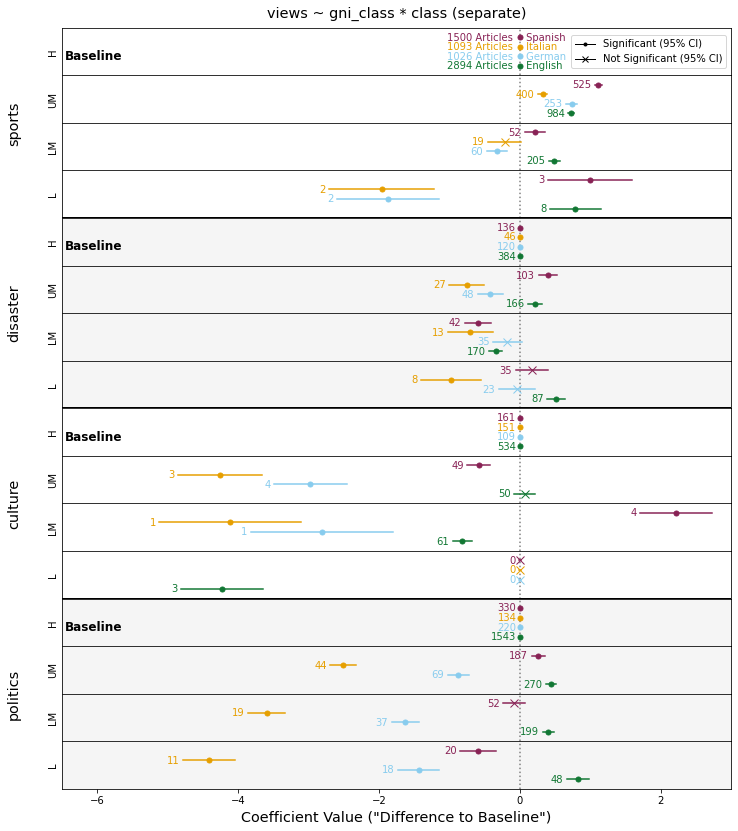

In [90]:
from regression import fit_regression_and_rename_coeffs_by_cat

results_fit_separate_class_controlcat = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                             formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_class, Treatment(reference='H')) + C(views_baseline_cat, Treatment(reference='>10^8'))",
                                                                             type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_class_controlcat,
                                                                      ['cat:gni_class'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='views ~ gni_class * class (separate)',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 14), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_class_controlcat.pdf')

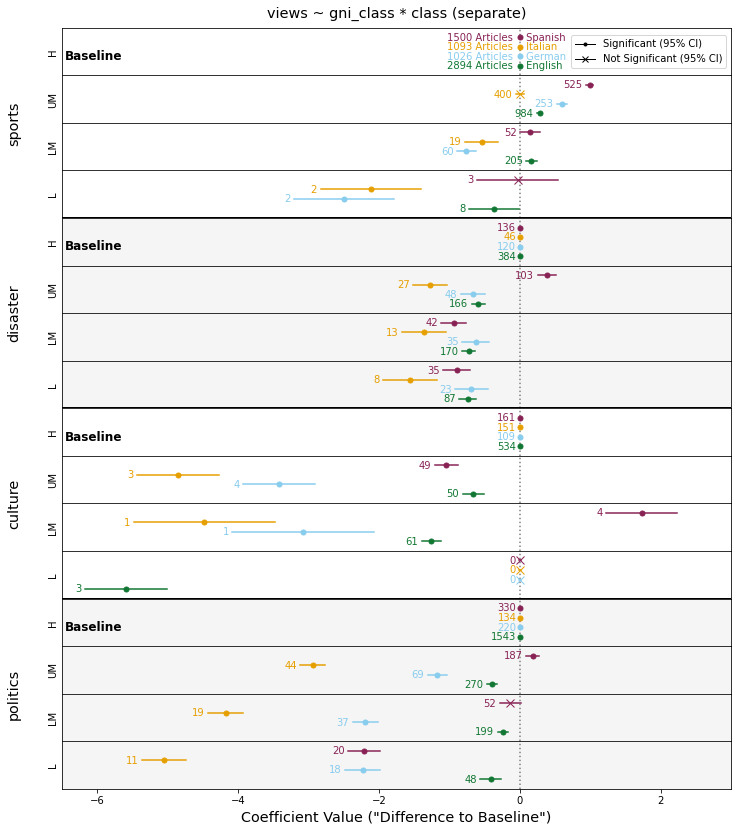

In [42]:
results_fit_separate_class = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                     formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_class, Treatment(reference='H'))",
                                                                     type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_class, ['cat:gni_class'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='views ~ gni_class * class (separate)',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 14), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_class.pdf')

In [91]:
results_fit_separate_class['en'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 7606
Model:                            GLM   Df Residuals:                     7590
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -87698.
Date:                Fri, 04 Mar 2022   Deviance:                       31200.
Time:                        11:20:03   Pearson chi2:                 1.38e+05
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1487
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          10.2361      0.019    550.648      0.000      10.200      10.272
cat[T.culture]                      0.5643      0.047     11.982      0.000       0.472       0.657
cat[T.disaster]                     1.4249      0.054     26.235      0.000       1.318       1.531
cat[T.politics]                     0.4850      0.032     15.387      0.000       0.423       0.547
gni_class[T.L]                     -0.3719      0.354     -1.050      0.294      -1.066       0.322
gni_class[T.LM]                     0.1645      0.072      2.276      0.023       0.023       0.306
gni_class[T.UM]                     0.2829      0.037      7.665      0.000       0.211       0.355
cat[T.culture]:gni_class[T.L]      -5.2208      0.680     -7.678      0.000      -6.554      -3.888
cat[T.disaster]:gni_class[T.L]     -0.3701      0.373     -0.991      0.322      -1.102       0.362
cat[T.politics]:gni_class[T.L]     -0.0414      0.383     -0.108      0.914      -0.792       0.710
cat[T.culture]:gni_class[T.LM]     -1.4242      0.153     -9.292      0.000      -1.725      -1.124
cat[T.disaster]:gni_class[T.LM]    -0.8932      0.117     -7.628      0.000      -1.123      -0.664
cat[T.politics]:gni_class[T.LM]    -0.4020      0.104     -3.851      0.000      -0.607      -0.197
cat[T.culture]:gni_class[T.UM]     -0.9450      0.152     -6.200      0.000      -1.244      -0.646
cat[T.disaster]:gni_class[T.UM]    -0.8704      0.100     -8.708      0.000      -1.066      -0.675
cat[T.politics]:gni_class[T.UM]    -0.6799      0.076     -8.994      0.000      -0.828      -0.532
===================================================================================================
"""

In [ ]:
results_fit_separate_region = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                      formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_region, Treatment(reference='North America'))",
                                                                      type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_region, ['cat:gni_region'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='views ~ gni_class * class (separate)',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 18), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_region.pdf')

In [47]:
df_filtered.views_baseline_cat.value_counts()

>10^7    4087
>10^6    3310
>10^8    2719
>10^5    2012
>10^9    1770
>10^4     650
>10^3     206
>10^2      33
>=0        14
Name: views_baseline_cat, dtype: int64

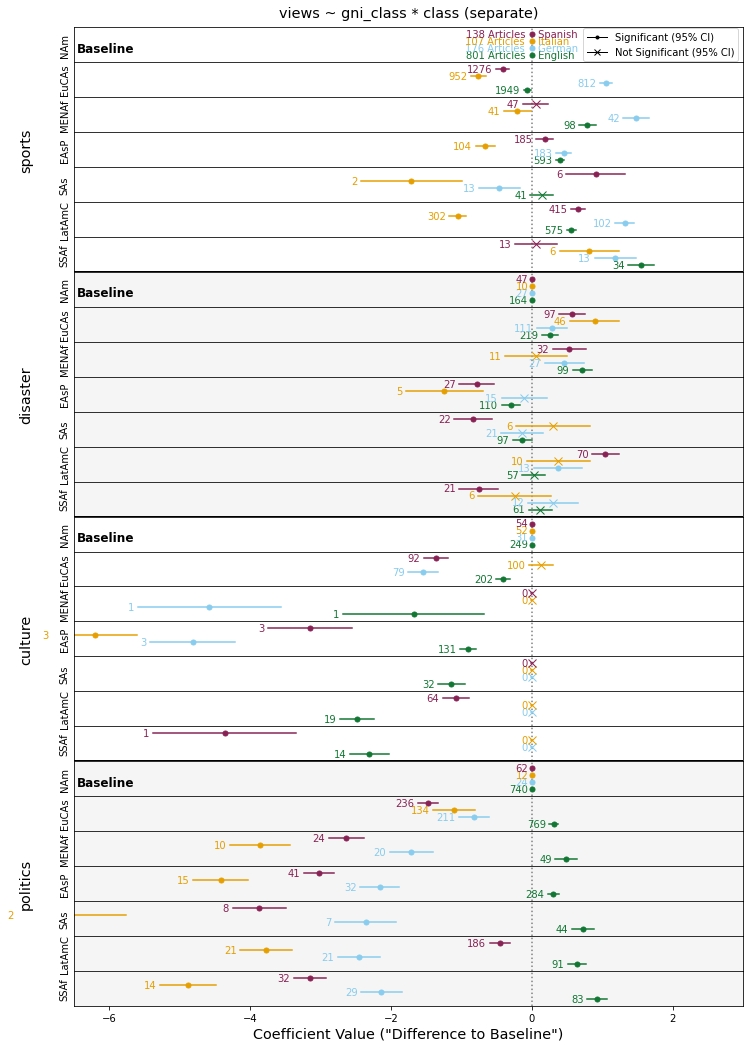

In [30]:
results_fit_separate_region = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                      formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_region, Treatment(reference='North America')) + np.log1p(views_baseline)",
                                                                      type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_region, ['cat:gni_region'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='views ~ gni_class * class (separate)',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 18), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_region_control.pdf')

In [45]:
results_fit_separate_class['en'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 7606
Model:                            GLM   Df Residuals:                     7590
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -87698.
Date:                Fri, 04 Mar 2022   Deviance:                       31200.
Time:                        10:11:50   Pearson chi2:                 1.38e+05
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1487
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          10.2361      0.019    550.648      0.000      10.200      10.272
cat[T.culture]                      0.5643      0.047     11.982      0.000       0.472       0.657
cat[T.disaster]                     1.4249      0.054     26.235      0.000       1.318       1.531
cat[T.politics]                     0.4850      0.032     15.387      0.000       0.423       0.547
gni_class[T.L]                     -0.3719      0.354     -1.050      0.294      -1.066       0.322
gni_class[T.LM]                     0.1645      0.072      2.276      0.023       0.023       0.306
gni_class[T.UM]                     0.2829      0.037      7.665      0.000       0.211       0.355
cat[T.culture]:gni_class[T.L]      -5.2208      0.680     -7.678      0.000      -6.554      -3.888
cat[T.disaster]:gni_class[T.L]     -0.3701      0.373     -0.991      0.322      -1.102       0.362
cat[T.politics]:gni_class[T.L]     -0.0414      0.383     -0.108      0.914      -0.792       0.710
cat[T.culture]:gni_class[T.LM]     -1.4242      0.153     -9.292      0.000      -1.725      -1.124
cat[T.disaster]:gni_class[T.LM]    -0.8932      0.117     -7.628      0.000      -1.123      -0.664
cat[T.politics]:gni_class[T.LM]    -0.4020      0.104     -3.851      0.000      -0.607      -0.197
cat[T.culture]:gni_class[T.UM]     -0.9450      0.152     -6.200      0.000      -1.244      -0.646
cat[T.disaster]:gni_class[T.UM]    -0.8704      0.100     -8.708      0.000      -1.066      -0.675
cat[T.politics]:gni_class[T.UM]    -0.6799      0.076     -8.994      0.000      -0.828      -0.532
===================================================================================================
"""

In [50]:
df_filtered.views_baseline_cat.value_counts()>10^9

>10^7    4087
>10^6    3310
>10^8    2719
>10^5    2012
>10^9    1770
>10^4     650
>10^3     206
>10^2      33
>=0        14
Name: views_baseline_cat, dtype: int64

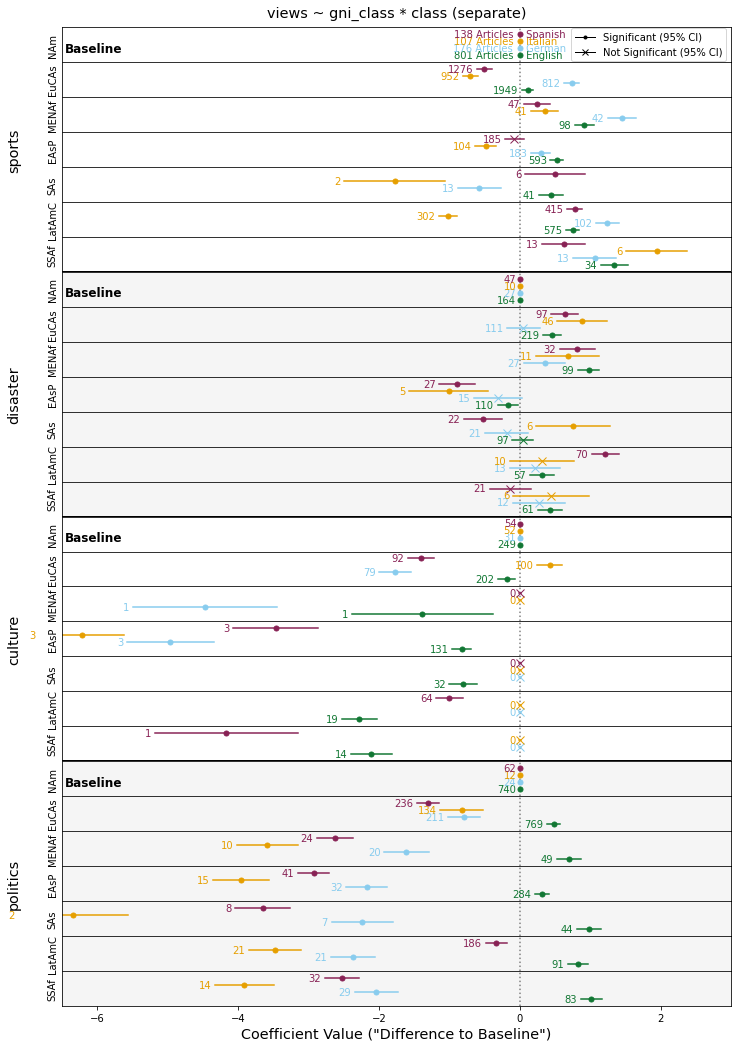

In [75]:
results_fit_separate_region_controlcat = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                      formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_region, Treatment(reference='North America')) + C(views_baseline_cat, Treatment(reference='>10^8'))",
                                                                      type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_region_controlcat, ['cat:gni_region'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='views ~ gni_class * class (separate)',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 18), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_region_controlcat.pdf')

In [ ]:
results_fit_separate_region['de'].summary2()

In [ ]:
results_fit_separate_region['de']

In [ ]:
 results_fit_separate_region['de'].summary()

In [ ]:
#fig.subplot
fig, axs = plt.subplots(ncols=4, figsize=(15, 3))
plot_pearson_residuals(df_filtered[df_filtered.code == 'de'], results_fit_separate_region['de'], title='de', ax=axs[0])
plot_pearson_residuals(df_filtered[df_filtered.code == 'en'], results_fit_separate_region['en'], title='en', ax=axs[1])
plot_pearson_residuals(df_filtered[df_filtered.code == 'es'], results_fit_separate_region['es'], title='es', ax=axs[2])
plot_pearson_residuals(df_filtered[df_filtered.code == 'de'], results_fit_separate_region['it'], title='it', ax=axs[3])
fig.tight_layout()

In [ ]:
#fig.subplot
fig, axs = plt.subplots(ncols=4, figsize=(15, 3))
plot_pearson_residuals(df_filtered[df_filtered.code == 'de'], results_fit_separate_region['de'], exclude_n_outliers=10,
                       title='de', ax=axs[0])
plot_pearson_residuals(df_filtered[df_filtered.code == 'en'], results_fit_separate_region['en'], exclude_n_outliers=10,
                       title='en', ax=axs[1])
plot_pearson_residuals(df_filtered[df_filtered.code == 'es'], results_fit_separate_region['es'], exclude_n_outliers=10,
                       title='es', ax=axs[2])
plot_pearson_residuals(df_filtered[df_filtered.code == 'de'], results_fit_separate_region['it'], exclude_n_outliers=10,
                       title='it', ax=axs[3])
fig.tight_layout()

In [ ]:
from plot_regression import compute_regression_outliers_from_residual

resid_outliers, outlier_filter = {}, {}
for code in ['de', 'it', 'es', 'en']:
    resid_outliers[code], outlier_filter[code] = compute_regression_outliers_from_residual(
        results_fit_separate_region[code])
all_outliers = pd.concat(resid_outliers.values())
all_filters = ~df_filtered.index.isin(all_outliers.index)

In [ ]:
from regression import fit_regression_and_rename_coeffs_by_cat

results_fit_separate_region_filtered = fit_regression_and_rename_coeffs_by_cat(df_filtered.loc[all_filters, :],
                                                                               formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_class, Treatment(reference='H'))",
                                                                               type='nb')

fig_int_class_cat_nb_filtered = plot_regression_results_interactions_from_dict(df_filtered.loc[all_filters, :],
                                                                               results_fit_separate_region_filtered,
                                                                               ['cat:gni_class'],
                                                                               {'gni_class': 'H', 'in_code_lang': True,
                                                                                'gni_region': 'North America',
                                                                                'cat': 'sports', 'code': 'en'},
                                                                               label_sort={
                                                                                   'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                   'cat': ['sports', 'disaster',
                                                                                           'culture', 'politics'],
                                                                                   'gni_region': ['North America',
                                                                                                  'Europe & Central Asia',
                                                                                                  'Middle East & North Africa',
                                                                                                  'East Asia & Pacific',
                                                                                                  'South Asia',
                                                                                                  'Latin America & Caribbean',
                                                                                                  'Sub-Saharan Africa']},
                                                                               cat_dict={'en': 'English',
                                                                                         'it': 'Italian',
                                                                                         'es': 'Spanish',
                                                                                         'de': 'German'},
                                                                               title='views ~ gni_class * class (separate)',
                                                                               label_rename_dict={
                                                                                   'Middle East & North Africa': 'MENAf',
                                                                                   'Latin America & Caribbean': 'LatAmC',
                                                                                   'Europe & Central Asia': 'EuCAs',
                                                                                   'East Asia & Pacific': 'EAsP',
                                                                                   'North America': 'NAm',
                                                                                   'Sub-Saharan Africa': 'SSAf',
                                                                                   'South Asia': 'SAs'},
                                                                               figsize=(12, 14), x_limits=(-6.5, 3),
                                                                               include_counts=True)

In [63]:
df_filtered.views_baseline_cat.value_counts()>10^9

>10^7    4087
>10^6    3310
>10^8    2719
>10^5    2012
>10^9    1770
>10^4     650
>10^3     206
>10^2      33
>=0        14
Name: views_baseline_cat, dtype: int64

In [92]:
results_fit_separate_class_controlcat['en'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 7606
Model:                            GLM   Df Residuals:                     7582
Model Family:        NegativeBinomial   Df Model:                           23
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -87118.
Date:                Fri, 04 Mar 2022   Deviance:                       30038.
Time:                        11:20:05   Pearson chi2:                 1.18e+05
No. Iterations:                    12   Pseudo R-squ. (CS):             0.2693
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     10.2799      0.029    353.298      0.000      10.223      10.337
cat[T.culture]                                                 0.2496      0.048      5.241      0.000       0.156       0.343
cat[T.disaster]                                                1.3356      0.055     24.481      0.000       1.229       1.443
cat[T.politics]                                                0.3646      0.033     11.190      0.000       0.301       0.428
gni_class[T.L]                                                 0.7875      0.360      2.187      0.029       0.082       1.493
gni_class[T.LM]                                                0.4910      0.074      6.655      0.000       0.346       0.636
gni_class[T.UM]                                                0.7264      0.039     18.618      0.000       0.650       0.803
views_baseline_cat, Treatment(reference='>10^8'))[T.>10^2]    -2.7591      1.003     -2.752      0.006      -4.724      -0.794
views_baseline_cat, Treatment(reference='>10^8'))[T.>10^3]    -0.9970      0.314     -3.179      0.001      -1.612      -0.382
views_baseline_cat, Treatment(reference='>10^8'))[T.>10^4]    -2.1721      0.124    -17.475      0.000      -2.416      -1.928
views_baseline_cat, Treatment(reference='>10^8'))[T.>10^5]    -1.2110      0.088    -13.743      0.000      -1.384      -1.038
views_baseline_cat, Treatment(reference='>10^8'))[T.>10^6]    -1.0130      0.050    -20.341      0.000      -1.111      -0.915
views_baseline_cat, Treatment(reference='>10^8'))[T.>10^7]    -0.4321      0.033    -13.286      0.000      -0.496      -0.368
views_baseline_cat, Treatment(reference='>10^8'))[T.>10^9]     0.4574      0.035     13.091      0.000       0.389       0.526
views_baseline_cat, Treatment(reference='>10^8'))[T.>=0]      -0.8525      0.709     -1.203      0.229      -2.242       0.536
cat[T.culture]:gni_class[T.L]                                 -5.0173      0.681     -7.367      0.000      -6.352      -3.682
cat[T.disaster]:gni_class[T.L]                                -0.2715      0.374     -0.725      0.468      -1.005       0.462
cat[T.politics]:gni_class[T.L]                                 0.0364      0.385      0.094      0.925      -0.719       0.792
cat[T.culture]:gni_class[T.LM]                                -1.3076      0.154     -8.500      0.000      -1.609      -1.006
cat[T.disaster]:gni_class[T.LM]                               -0.8349      0.117     -7.116      0.000      -1.065      -0.605
cat[T.politics]:gni_class[T.LM]                               -0.0899      0.105     -0.854      0.393      -0.296       0.117
cat[T.culture]:gni_class[T.UM]     

In [77]:
df_filtered.groupby(['code', 'views_baseline_cat']).count()

event_id  pagetitle  event_date  economic_region  \
code views_baseline_cat                                                     
de   >10^2                      8          8           8                8   
     >10^3                     62         62          62               62   
     >10^4                    177        177         177              177   
     >10^5                    418        418         418              418   
     >10^6                    888        888         888              888   
     >10^7                    293        293         293              293   
     >10^8                    175        175         175              175   
     >=0                        4          4           4                4   
en   >10^2                      1          1           1                1   
     >10^3                     11         11          11               11   
     >10^4                     72         72          72               72   
     >10^5                    193        193         193              193   
     >10^6                    683        683         683              683   
     >10^7                   3250       3250        3250             3250   
     >10^8                   1624       1624        1624             1624   
     >10^9                   1770       1770        1770             1770   
     >=0                        2          2           2                2   
es   >10^2                     17         17          17               17   
     >10^3                     97         97          97               97   
     >10^4                    225        225         225              225   
     >10^5                    664        664         664              664   
     >10^6                   1141       1141        1141             1141   
     >10^7                    537        537         537              537   
     >10^8                    512        512         512              512   
     >=0                        6          6           6                6   
it   >10^2                      7          7           7                7   
     >10^3                     36         36          36               36   
     >10^4                    176        176         176              176   
     >10^5                    737        737         737              737   
     >10^6                    598        598         598              598   
     >10^7                      7          7           7                7   
     >10^8                    408        408         408              408   
     >=0                        2          2           2                2   

                         country  continent   cat  categories  views_7_sum  \
code views_baseline_cat                                                      
de   >10^2                     8          8     8           8            8   
     >10^3                    62         62    62          62           62   
     >10^4                   177        177   177         177          177   
     >10^5                   418        418   418         418          418   
     >10^6                   888        888   888         888          888   
     >10^7                   293        293   293         293          293   
     >10^8                   175        175   175         175          175   
     >=0                       4          4     4           4            4   
en   >10^2                     1          1     1           1            1   
     >10^3                    11         11    11          11           11   
     >10^4                    72         72    72          72           72   
     >10^5                   193        193   193         193          193   
     >10^6                   683        683   683         683          683   
     >10^7                  3250       3250  3250        3250         3250   
     >10^8                  1624       1624  1624        1624         1624   
   

In [ ]:
## Try out views parameter

In [ ]:
from steinkasserer.regression import fit_negative_binomial_regression_and_rename_coeffs

results_nb = fit_negative_binomial_regression_and_rename_coeffs(df_filtered,
                                                                formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_class, Treatment(reference='H')) * C(code, Treatment(reference='en')) + np.log1p(views_baseline) + in_code_lang")
results_nb_base = fit_negative_binomial_regression_and_rename_coeffs(df_filtered,
                                                                     formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(code, Treatment(reference='en'))")
results_nb.summary()

In [ ]:
df_filtered

In [ ]:
df_filtered

In [ ]:
np.sum(np.square(results_nb.resid_pearson)) / results_nb.df_resid